In [1]:
# Obucavanje se vrsi baseline-u dok se testiranje vrsi na ostalim segmentima
# Testirani modeli su: RF, SVM, GNB, LDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from scipy import stats

In [3]:
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support

In [5]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, cohen_kappa_score, accuracy_score

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
import pickle

In [8]:
%matplotlib inline

In [9]:
dat_12_samples = pd.read_csv('/Features.csv',sep=',')
dat_8_samples = pd.read_csv('/Features_without_neutral.csv',sep=',')

In [10]:
dat_baseline = pd.DataFrame([],columns=dat_12_samples.columns)
dat_anger = pd.DataFrame([],columns=dat_12_samples.columns)
dat_neutral = pd.DataFrame([],columns=dat_12_samples.columns)

In [11]:
dat = pd.concat([dat_12_samples,dat_8_samples])

In [12]:
for i in range(len(dat)):
    temp = dat.iloc[i,0]
    if temp[-1] == '1':
        dat_baseline = dat_baseline.append(dat.iloc[i],ignore_index=True)
    elif temp[-1] == '2':
        dat_anger = dat_anger.append(dat.iloc[i],ignore_index=True)
    elif temp[-1] == '3':
        dat_neutral = dat_neutral.append(dat.iloc[i],ignore_index=True)

In [13]:
for i in range(len(dat_baseline)):
    temp = dat_baseline.iloc[i,0]
    dat_baseline.iloc[i,0] = temp[:-4]

for i in range(len(dat_anger)):
    temp = dat_anger.iloc[i,0]
    dat_anger.iloc[i,0] = temp[:-4]

for i in range(len(dat_neutral)):
    temp = dat_neutral.iloc[i,0]
    dat_neutral.iloc[i,0] = temp[:-4]

In [14]:
skf = StratifiedKFold(n_splits=4, shuffle=True) 

In [15]:
with open('best_params_all.pkl', 'rb') as f:
    best_params_all = pickle.load(f)

In [16]:
le = LabelEncoder()

dat_anger['examinee'] = le.fit_transform(dat_anger['examinee'])
dat_baseline['examinee'] = le.transform(dat_baseline['examinee'])
dat_neutral['examinee'] = le.transform(dat_neutral['examinee'])

In [17]:
X_train = dat_anger.drop('examinee',axis=1)
y_train = dat_anger['examinee']

In [18]:
X_baseline = dat_baseline.drop('examinee',axis=1)
y_baseline = dat_baseline['examinee']

In [19]:
X_neutral = dat_neutral.drop('examinee',axis=1)
y_neutral = dat_neutral['examinee']

In [20]:
scaler = StandardScaler()

In [21]:
X_train_scaled = scaler.fit_transform(X_train)
X_neutral_scaled = scaler.transform(X_neutral)
X_baseline_scaled = scaler.transform(X_baseline)

In [22]:
X = X_train
y = y_train

In [23]:
num_runs = 20

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rforest_scores = np.zeros((3,1))
rforest_precision_recall_fscore = np.zeros((3,3))

temp = []
# for i in range(num_runs):
rforest = RandomForestClassifier(**best_params_all['RF'])
rforest_scores[1] = np.mean(cross_val_score(rforest, X_train, y_train, cv = skf))
rforest_precision_recall_fscore[1,0] = np.mean(cross_val_score(rforest, X_train, y_train, cv=skf, scoring='precision_weighted'))
rforest_precision_recall_fscore[1,1] = np.mean(cross_val_score(rforest, X_train, y_train, cv=skf, scoring='recall_weighted'))
rforest_precision_recall_fscore[1,2] = np.mean(cross_val_score(rforest, X_train, y_train, cv=skf, scoring='f1_weighted'))
rforest.fit(X_train,y_train)
y_hat = rforest.predict(X_baseline)
rforest_scores[0] = accuracy_score(y_baseline, y_hat)
rforest_precision_recall_fscore[0,:] = precision_recall_fscore_support(y_baseline,y_hat,average='weighted')[:3]
y_hat = rforest.predict(X_neutral)
rforest_scores[2] = accuracy_score(y_neutral, y_hat)
rforest_precision_recall_fscore[2,:] = precision_recall_fscore_support(y_neutral,y_hat,average='weighted')[:3]

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [27]:
lda_scores = np.zeros((3,1))
lda_precision_recall_fscore = np.zeros((3,3))

temp = []
# for i in range(num_runs):
lda = LinearDiscriminantAnalysis(**best_params_all['LDA'])
lda_scores[1] = np.mean(cross_val_score(lda, X_train_scaled, y_train, cv = skf))
lda_precision_recall_fscore[1,0] = np.mean(cross_val_score(lda, X_train_scaled, y_train, cv=skf, scoring='precision_weighted'))
lda_precision_recall_fscore[1,1] = np.mean(cross_val_score(lda, X_train_scaled, y_train, cv=skf, scoring='recall_weighted'))
lda_precision_recall_fscore[1,2] = np.mean(cross_val_score(lda, X_train_scaled, y_train, cv=skf, scoring='f1_weighted'))    
lda.fit(X_train_scaled,y_train)
y_hat = lda.predict(X_baseline_scaled)
lda_scores[0] = accuracy_score(y_baseline, y_hat)
lda_precision_recall_fscore[0,:] = precision_recall_fscore_support(y_baseline,y_hat,average='weighted')[:3]
y_hat = lda.predict(X_neutral_scaled)
lda_scores[2] = accuracy_score(y_neutral, y_hat)
lda_precision_recall_fscore[2,:] = precision_recall_fscore_support(y_neutral,y_hat,average='weighted')[:3]

In [28]:
from sklearn.naive_bayes import GaussianNB

In [29]:
gnb_scores = np.zeros((3,1))
gnb_precision_recall_fscore = np.zeros((3,3))

# for i in range(num_runs):
gnb = GaussianNB(**best_params_all['GNB'])
gnb_scores[1] = np.mean(cross_val_score(gnb, X_train_scaled, y_train, cv = skf))
gnb_precision_recall_fscore[1,0] = np.mean(cross_val_score(gnb, X_train_scaled, y_train, cv=skf, scoring='precision_weighted'))
gnb_precision_recall_fscore[1,1] = np.mean(cross_val_score(gnb, X_train_scaled, y_train, cv=skf, scoring='recall_weighted'))
gnb_precision_recall_fscore[1,2] = np.mean(cross_val_score(gnb, X_train_scaled, y_train, cv=skf, scoring='f1_weighted'))  
gnb.fit(X_train_scaled,y_train)
y_hat = gnb.predict(X_baseline_scaled)
gnb_scores[0] = accuracy_score(y_baseline, y_hat)
gnb_precision_recall_fscore[0,:] = precision_recall_fscore_support(y_baseline,y_hat,average='weighted')[:3]
y_hat = gnb.predict(X_neutral_scaled)
gnb_scores[2] = accuracy_score(y_neutral, y_hat)
gnb_precision_recall_fscore[2,:] = precision_recall_fscore_support(y_neutral,y_hat,average='weighted')[:3]

In [30]:
from sklearn.svm import SVC

In [31]:
svm_scores = np.zeros((3,1))
svm_precision_recall_fscore = np.zeros((3,3))
temp = []
# for i in range(num_runs):
svm = SVC(**best_params_all['SVM'])
svm_scores[1] = np.mean(cross_val_score(svm, X_train_scaled, y_train, cv = skf))
svm_precision_recall_fscore[1,0] = np.mean(cross_val_score(svm, X_train_scaled, y_train, cv=skf, scoring='precision_weighted'))
svm_precision_recall_fscore[1,1] = np.mean(cross_val_score(svm, X_train_scaled, y_train, cv=skf, scoring='recall_weighted'))
svm_precision_recall_fscore[1,2] = np.mean(cross_val_score(svm, X_train_scaled, y_train, cv=skf, scoring='f1_weighted'))  
svm.fit(X_train_scaled,y_train)
y_hat = svm.predict(X_baseline_scaled)
svm_scores[0] = accuracy_score(y_baseline, y_hat)
svm_precision_recall_fscore[0,:] = precision_recall_fscore_support(y_baseline,y_hat,average='weighted')[:3]
y_hat = svm.predict(X_neutral_scaled)
svm_scores[2] = accuracy_score(y_neutral, y_hat)
svm_precision_recall_fscore[2,:] = precision_recall_fscore_support(y_neutral,y_hat,average='weighted')[:3]

In [32]:
temp = np.mean(rforest_scores, axis=0)

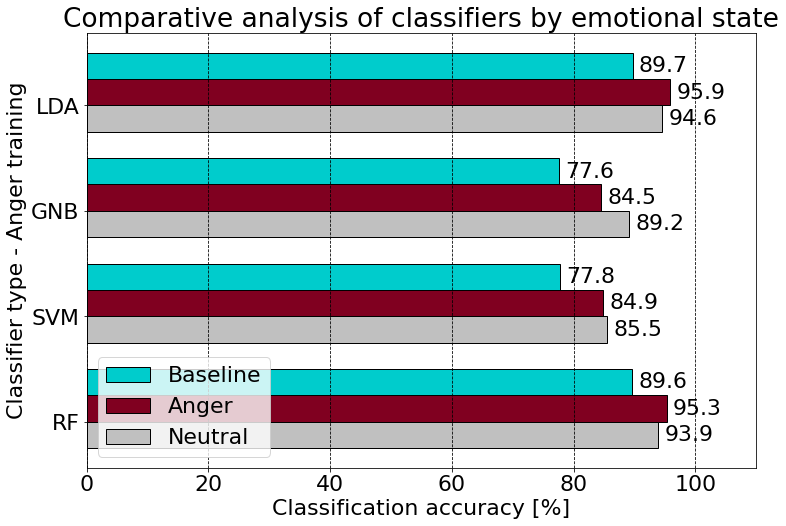

In [33]:
labels = ['RF', 'SVM', 'GNB', 'LDA']
baseline_acc = [float(rforest_scores[0]) * 100, float(svm_scores[0]) * 100, float(gnb_scores[0]) * 100, float(lda_scores[0]) * 100]
anger_acc = [float(rforest_scores[1]) * 100, float(svm_scores[1]) * 100, float(gnb_scores[1]) * 100, float(lda_scores[1]) * 100]
neutral_acc = [float(rforest_scores[2]) * 100, float(svm_scores[2]) * 100, float(gnb_scores[2]) * 100, float(lda_scores[2]) * 100]

plt.rcParams.update({'font.size': 22})

n = 4
r = np.arange(n)
height = 0.25

plt.figure(figsize=(12, 8))
plt.barh(r + 2 * height, baseline_acc, color='#00CCCC',
         height=height, edgecolor='black',
         label='Baseline')
plt.barh(r + height, anger_acc, color='#800020',
         height=height, edgecolor='black',
         label='Anger')
plt.barh(r, neutral_acc, color='#C0C0C0',
         height=height, edgecolor='black',
         label='Neutral')

plt.grid(axis='x', linestyle='--', color='black')
plt.yticks(r + height/2, labels)
plt.legend(loc='lower left')
plt.xlabel('Classification accuracy [%]')
plt.ylabel('Classifier type - Anger training')
plt.title('Comparative analysis of classifiers by emotional state')
plt.xlim((0, 110))

for i, v in enumerate(neutral_acc):
    plt.text(v + 1, i, f'{v:.1f}', color='black', va='center')

for i, v in enumerate(anger_acc):
    plt.text(v + 1, i + height, f'{v:.1f}', color='black', va='center')

for i, v in enumerate(baseline_acc):
    plt.text(v + 1, i + 2 * height, f'{v:.1f}', color='black', va='center')

plt.show()


In [34]:
print(np.round(svm_precision_recall_fscore*100,2).T)

[[79.41 78.93 90.63]
 [77.85 85.15 85.49]
 [75.61 82.08 85.78]]
